In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

import thinkbayes
from thinkbayes import Pmf
from thinkbayes import Suite
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# 의사 결정 분석
___
## 1. '$The\ Price\ is\ Right$*(그 가격이 적당해요)*' 문제

>- A와 B가 진열대 위 물건의 가격을 맞추는 게임에 참가
>- 진열대 가격을 넘기 않는 한도 내에서 가장 가까운 가격을 부르는 사람이 승리
>- A는 \$26,000을 예상하였고 실제 가격은 \$25,347
>- B는 \$21,500을 예상하였고 실제 가격은 \$21,578
>- B는 -\$78 차이로 승리했을 뿐 아니라 예상가와 금액차이가 \$250 보다 작아 A의 진열대 물건까지 확보(게임룰)

- 베이지안 사고 방식을 갖고 있는 사람들에게, 위 시나리오는 다음 3가지 질문을 던짐
> 1. 결과를 보기 전에, 진열대 가격에 대한 사전분포를 얼마나 믿고 있었을까?
> 2. 결과 확인 후 가격에 대한 믿음의 사후분포가 바뀌었을까?
> 3. 사후분포에 따르면 참가자는 얼마를 부르는 것이 유리한가?

___
## 2. 사전 분포

- '$The\ Price\ is\ Right$'의 [2011년](http://thinkbayes.com/showcases.2011.csv), [2012년](http://thinkbayes.com/showcases.2012.csv) 시즌 별 각 회차의 금액과 참가자들의 예상가는 링크 에서 확인 가능
- KDE로 다듬어진 분포는 아래 그래프에서 확인 가능

In [2]:
biddings = pd.merge(pd.read_csv('data/showcases.2011.csv')[2:10],pd.read_csv('data/showcases.2012.csv')[1:9], on = 'Unnamed: 0')
biddings.index = biddings['Unnamed: 0']
biddings.index.name = ''
biddings = biddings.iloc[:,1:]
biddings = biddings.iloc[[0,1,6,7,8,9],:]
biddings = biddings.astype(int)
biddings = biddings.T

Text(0,0.5,'PDF')

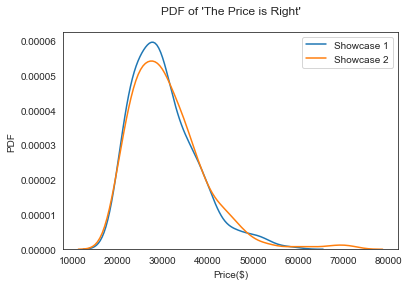

In [3]:
sns.set_style('white')
sns.distplot(biddings['Showcase 1'], label = 'Showcase 1', hist = False)
sns.distplot(biddings['Showcase 2'], label = 'Showcase 2', hist = False)
plt.legend()
plt.title("PDF of 'The Price is Right'\n")
plt.xlabel("Price($)")
plt.ylabel('PDF')
#plt.set(xlabel= 'Price($)', ylabel = 'PDF')

___
## 3. 확률 밀도 함수 (PDF)

- 그동안은 이산형 밀도 함수인 PMF를 다뤄왔고, 각 Pmf object별로 확률값을 반환함
- **연속확률함수(PDF)**은 연속형 PMF로 보통 함수 형식으로 표시함
- 다음은 평균이 0이고 표준편차가 1인 가우시간 분포의 PDF를 나타낸 것 $N(0, 1)$
$$
f(x) = \frac{1}{\sqrt{2\pi}}exp(-x^2/2)
$$

- 위 함수는 주어진 $x$에 대한 확률 밀도를 계산
- PDF는 값이 클수록 근사값에 가까워지지만, 0부터 무한대까지 값을 가질 수 있어 확률로 볼 수는 없음
- 다만 이를 연속적 범위로 적분한다면 확률로 반환은 가능

___
## 4. PDF 나타내기

- thinkbayes는 `Pdf`라는 클래스를 통해 **추상형** 인터페이스 구축
- `Pdf` 인터페이스는 `Density`와 `MakePmf` 두가지 방법을 포함
```python
class Pdf(object):
    
    def Density(self, x):
        raise UnimplmentedMethodException()
    
    def MakePmf(self, xs):
        pmf = Pmf()
        for  x  in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf
```

- `Density`는 값 x를 받아서 이에 해당하는 확률 밀도를 반환
- `MakePmf`는 PDF의 이산형 추정값을 반환

- 가우시안 PDF 같은 경우는 간단한 수학 함수로 정의되어 구현하기도 쉬움 (실생활에서 빈번하게 나타나기도 함)
- 하지만 실제 데이터의 분포를 다른 함수로 나타낼 수 있다는 보장은 없으며, **전체 PDF를 추정하기 위해 샘플을 사용**
- $The\ Price\ is\ Right$ 예제에서는 1회차에 대해 313개의 데이터가 있으며, 순서대로 나열할 시 아래같이 나타남

In [4]:
biddings.sort_values('Showcase 1').head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
Jan. 13,19563,33551,28500,30000,-8937,3551
Dec. 23,19612,23084,17500,21000,2112,2084
Apr. 17,20408,34453,18200,36100,2208,-1647
Mar. 20_x,20418,25541,24622,23000,-4204,2541
Jan. 16_x,20418,29524,22000,22750,-1582,6774


- 이 경우 `[19563, 19612, 20408, 20418, 20418]`의 관측값이 있으며, 19564가 관측되지 않았다고 해서 나올 일이 없다고 판단내릴 근거가 없음
- 배경 지식을 기반으로 범위 내 값일 가능성이 있는 모든 값을 예상해야 하며, 이는 곧 **PDF 곡선을 부드럽게 유추하는 과정**으로 볼 수 있음
- **KDE(커널 밀도 추정)**은 샘플로 데이터에 적합한 추정PDF를 찾아내는 것임

In [5]:
price = biddings[['Showcase 1', 'Showcase 2']]
pdf1 = thinkbayes.EstimatedPdf(price['Showcase 1'])
pdf2 = thinkbayes.EstimatedPdf(price['Showcase 1'])
bins = np.linspace(0, 75000, 101)
pmf1 = pdf1.MakePmf(bins)
pmf2 = pdf2.MakePmf(bins)

pmf = pd.DataFrame([pmf1.d, pmf2.d], columns = pmf1, index = ['Showcase 1', 'Showcase 2']).T
pmf.head()

,Showcase 1,Showcase 2
,,
0.0,5.313183e-20,5.313183e-20
750.0,8.964307e-19,8.964307e-19
1500.0,1.358400e-17,1.358400e-17
2250.0,1.849389e-16,1.849389e-16
3000.0,2.262964e-15,2.262964e-15


- 비어 있는 관측값이 있으므로 0~75,000까지의 범위로 PDF 생성
- PDF로부터 역으로 PMF 생성

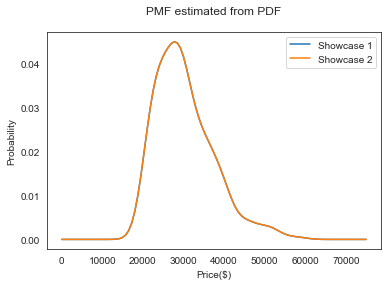

In [6]:
sns.lineplot(x = pmf.index, y = pmf.iloc[:,0], label = 'Showcase 1')
sns.lineplot(x = pmf.index, y = pmf.iloc[:,1], label = 'Showcase 2')
plt.title('PMF estimated from PDF\n')
plt.xlabel('Price($)')
plt.ylabel('Probability')
plt.legend()

___
## 5. 참가자 모델링

- 틀린 정보가 주어졌을 때 이를 기반으로 금액을 추측하기 위한 모델 생성
> 1. 어떤 데이터를 고려해야 하고, 어떤 데이터를 수치화 해야 할까?
> 2. 우도 함수를 계산할 수 있을까?  
>    즉, 각 price에 대한 가설 값을 정하면서 데이터의 상태우도를 계산할 수 있을까?

- 실제 가격이 $price$, 참가자의 추정이 $guess$일 때, 우도는 다음과 같이 정의 가능  
$error = price - guess$
- $error$의 우도를 구하는데에는 과거의 데이터를 참조할 필요가 있음
- 데이터에는 실제 가격 $price$와 참가자들의 배당 금액에 해당하는 $bid$가 정의되어 있고, 그 차이인 $diff$도 확인 가능  
$diff = price - bid$

In [7]:
diff = biddings[['Difference 1', 'Difference 2']]
diff
diff_bins = np.linspace(-30000, 50000, 101)
diff1 = thinkbayes.EstimatedPdf(diff['Difference 1']).MakePmf(diff_bins).d
diff2 = thinkbayes.EstimatedPdf(diff['Difference 2']).MakePmf(diff_bins).d
diff_pmf = pd.DataFrame([diff1, diff2], columns = diff1.keys()).T
diff_pmf.head()

,0,1
-30000.0,3.169212e-15,0.000076
-29200.0,4.226390e-14,0.000143
-28400.0,4.931661e-13,0.000235
-27600.0,5.035540e-12,0.000337
-26800.0,4.499474e-11,0.000424


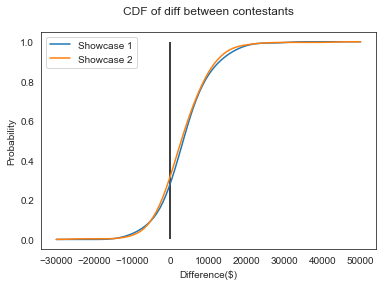

In [8]:
sns.lineplot(x = diff_pmf.index, y = diff_pmf.cumsum().iloc[:,0], label = 'Showcase 1')
sns.lineplot(x = diff_pmf.index, y = diff_pmf.cumsum().iloc[:,1], label = 'Showcase 2')
plt.title('CDF of diff between contestants\n')
plt.legend()
plt.xlabel('Difference($)')
plt.ylabel('Probability')
plt.vlines(x = 0, ymin = 0, ymax = 1)

- 입찰금액과 실제금액간의 차이를 보면 양수 쪽으로 치우쳐져 있는 것을 볼수 있음
- 이는 입찰금액이 실제금액보다 높으면 탈락이라는 게임 룰이 반영된 현상으로 볼 수 있음

In [9]:
sum(diff.iloc[:,0]<0)/ len(diff), sum(diff.iloc[:,1]<0) / len(diff)

(0.24600638977635783, 0.29073482428115016)

- 각각 전체에서 25%, 29%만 입찰금액에 실제 금액보다 높게 나타남

- 마지막으로 분포를 사용하여 참가자들의 추측 신뢰도를 확인 해 볼 수 있음
- 단, error의 분포는 $N(0,1)$을 따른다고 가정

In [10]:
class Players(object):
    def __init__(self, prices, bids, diffs):
        self.pdf_price = thinkbayes.EstimatedPdf(prices)
        self.cdf_diff = thinkbayes.MakeCdfFromList(diffs)
        
        mu = 0
        sigma = np.std(diffs)
        self.pdf_error = thinkbayes.GaussianPdf(mu, sigma)

- `pdf_price`는 KDE로 추정한 가격에 대해서 평활화된 PDF임
- `cdf_diff`는 diff의 누적분포로 아래 그래프와 같음
- `pdf_error`는 error의 분포를 나타낸 PDF임 ($N(0,std(diff))$를 따르는)

In [83]:
p1 = Players(prices = biddings['Showcase 1'], bids = biddings['Bid 1'], diffs = biddings['Difference 1'])
p2 = Players(prices = biddings['Showcase 2'], bids = biddings['Bid 2'], diffs = biddings['Difference 2'])

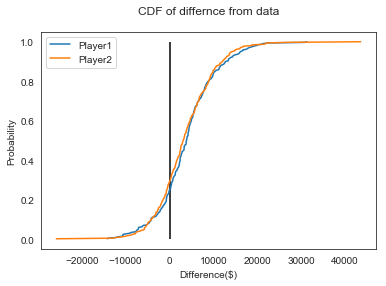

In [12]:
sns.lineplot(x = p1.cdf_diff.Values(), y = p1.cdf_diff.ps, label = 'Player1')
sns.lineplot(x = p2.cdf_diff.Values(), y = p2.cdf_diff.ps, label = 'Player2')
plt.title('CDF of differnce from data\n')
plt.xlabel('Difference($)')
plt.ylabel('Probability')
plt.vlines(x = 0, ymin = 0, ymax = 1)

___
## 6. 우도 / 7. 갱신

In [60]:
class Price(thinkbayes.Suite):
    
    def __init__(self, pmf, player):
        thinkbayes.Suite.__init__(self, pmf)
        self.player = player
        
    def Likelihood(self, data, hypo):
        price = hypo
        guess = data
        
        error = price - guess
        like = self.player.ErrorDensity(error)
        
        return like


In [53]:
class Players(object):
    def __init__(self, prices, bids, diffs):
        self.pdf_price = thinkbayes.EstimatedPdf(prices)
        self.cdf_diff = thinkbayes.MakeCdfFromList(diffs)
        
        mu = 0
        sigma = np.std(diffs)
        self.pdf_error = thinkbayes.GaussianPdf(mu, sigma)
        
    def ErrorDensity(self, error):
        return self.pdf_error.Density(error)
    
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self)
        self.posterior = self.prior.Copy()
        self.posterior.Update(guess)
        
    n = 101
    price_xs = numpy.linspace(0, 75000, n)
    
    def PmfPrice(self):
        return self.pdf_price.MakePmf(self.price_xs)


- `thinkbayes.Suite`을 확장한 새 클래스를 정의
- `pmf`는 사전 분포를 나타냄
- `player`는 앞장에서 정의한 `Player`객체로 추가로 기능 정의 예정
```python
class Price(thinkbayes.Suite):

    def __init__(self, pmf, player):
        thinkbayes.Suite.__init__(self.pmf)
        self.player = player
```

___
#### 우도
- `Price.Likelihood`는 다음과 같음
- `hypo`는 진열장의 가격, `data`는 참가자들이 추정한 값, `error`는 차이값, `like`은 해당 가설에 대한 데이터의 우도
```python
#class Price:
    def Likelihood(self, data, hypo):
        price = hypo
        guess = data

        error = price - guess
        like = self.player.ErrorDensity(error)

        return like
```

- `Player.ErrorDensity`는 주어진 `error`값들에 대해 PDF를 계산
- `ErrorDensity`값은 확률밀도값으로 비율에 해당 (정규화를 통해 확률로 전환)
```python
#class Player:
    def ErrorDensity(self, error):
        return self.pdf_error.Density(error)
```


___
#### 갱신
- `Player.MakeBeliefs`는 아래와 같음
- `Player` 클래스를 통해 참가자의 예측값을 가지고 사후확률을 산출
- `Player.PmfPrice()`는 `Pdf.MakePmf` 함수를 사용해서 가격의 PDF 근사치를 만들어내고 이는 곧 사전확률임
- `Player.PmfPrice()`는 `pdf_price = thinkbayes.EstimatedPdf(prices)`를 물려받아서 연산
- 사후확률을 만들기 위해 사전확률의 `copy`를 만들고 `Update`메서드로 우도를 반영
```python
#class Player
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self)
        self.posterior = self.prior.Copy()
        self.posterior.Update(guess)
    
    n = 101
    
    price_xs = np.linspace(0, 75000, n)
    
    def PmfPrice(self):
        return self.pdf_price.MakePmf(self.price_xs)
    ```

- 실제 문제로 돌아와서 Player1이 진열대 가격을 \$20,000으로 예측하였다면, 사후분포를 아래와 같이 업데이트 가능

In [85]:
p1.MakeBeliefs(20000)

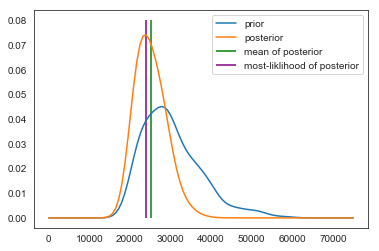

In [109]:
sns.lineplot(x = list(p1.prior.d.keys()), y = list(p1.prior.d.values()), label = 'prior')
sns.lineplot(x = list(p1.posterior.d.keys()), y = list(p1.posterior.d.values()), label = 'posterior')
plt.vlines(x = p1.posterior.Mean(), ymin = 0, ymax = 0.08, label = 'mean of posterior', colors = 'green')
plt.vlines(x = p1.posterior.MaximumLikelihood(), ymin = 0, ymax = 0.08, label = 'most-liklihood of posterior', color = 'purple')
plt.legend()

- 사전 분포에서 최대 우도 값이 \$27,750일 때, \$20,000으로 우도를 갱신하여 사후분포를 산출
- 사후 분포의 평균은 \$25,096, 사후분포의 최대우도는 \$24,000이 최적의 값이라고 주장

In [111]:
p1.prior.MaximumLikelihood(), p1.posterior.Mean(), p1.posterior.MaximumLikelihood()

(27750.0, 25096.41181620624, 24000.0)

- 위 의사결정에서 중요한 점은 두 정보를 잘 조합해야 한다는 것임
> 1. 쇼케이스의 과거 데이터
> 2. 추측한 진열장 아이템 가격  
- 이전까지는 1번을 **'사전분포'**로 두고, 2번 정보로 **'갱신'**하여 **'사후분포'**를 산출
- 2번을 **'사전분포'**로, 1번 정보로 **'갱신'**하여 '사후분포'를 산출하게되면 다른 결과를 기대할 수 있으며, 보다 합리적인 결과가 나올 수도 있음

___
## 8. 최적 입찰

___
## 참조. thinkbayes(Pdf) 하위 클래스

- GaussianPdf: Pdf를 확장한 형태로 Density 제공
```python
class GaussianPdf(Pdf):
    def __init__ (self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def Density(self, x):
            return scipy.stats.norm.pdf(x, self.mu, self.sigma)
        ```
        
- EstimatedPdf: 커널 밀도추정갑 계산
```python
class EstimatedPdf(Pdf):
    def __init__(self,sample):
        self.kde = scipy.stats.gaussian_kde(sample)
    def Density(self, x):
        return self.kde.evaluate(x)
        ```

In [13]:
class GaussianPdf(thinkbayes.Pdf):
    def __init__ (self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def Density(self, x):
        return scipy.stats.norm.pdf(x, self.mu, self.sigma)
class EstimatedPdf(thinkbayes.Pdf):
    def __init__(self,sample):
        self.kde = scipy.stats.gaussian_kde(sample)
    def Density(self, x):
        return self.kde.evaluate(x)